# Intro Call Scoring Model - Lead + IntroCall

Goals of the project:
    
    1) Determine if correlations between key sales indicators (account level demographics, lead characteritics, etc) and qualification/deal oppty exist.
    
    2) Is there a statistically significant difference between qualified and disqualified intro calls in regards to information given?
    
    3) Create machine learning model that allows us to predict whether an introcall will be qualified, whether opportunity will result, and the value of the resulting opportunity. Look at important features as well.

In [1]:
import psycopg2
from sqlalchemy.engine import url as sa_url
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
#function to clean dates
def clean_dates(df, oldColName, newColName, timedatepattern):
    """This will take a dataframe, a number of column names & create new columns of datetime objects"""
    emptyDateFrame = []
    colPosition = len(df.columns)
    for date in df[oldColName]:
        if date != None:
                if pd.isna(date):
                        emptyDateFrame.append(np.nan)
                else:        
                        if isinstance(date, str):
                                emptyDateFrame.append(datetime.datetime.strptime(date, timedatepattern))
                        else:
                                emptyDateFrame.append(datetime.datetime.strptime(str(date), timedatepattern))
        else:
            emptyDateFrame.append(None)
    df.insert(colPosition, newColName, emptyDateFrame)
    del df[oldColName]
    return df

In [3]:
#function to rempa values based on provded dicts
def clean_map(df, dictToMap, oldColName):
    """This will take a dataframe, 
    a number of column names & 
    create new columns of datetime objects"""
    newColName = oldColName + "_map"
    df[newColName] = df[oldColName].map(dictToMap) 
    del df[oldColName]
    return df


engine = create_engine('redshift+psycopg2://username@host.amazonaws.com:5439/database')

In [4]:
# Query vis SQL Aclhemy th Leads and Introcalls tables to create the lead scoring table

leads_raw = pd.read_csv('leads_full_data.csv')

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,64,66,72,73,74,75,78,79,83,84,89,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Intro Calls

intro_calls_raw = pd.read_csv('intro_calls_full_data.csv')

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (85,93,107,109,113) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Description

In [6]:
# Lead Data
print("___________________________________Summary on Leads Object___________________________________")
print("Leads Raw Info:", leads_raw.info())
print("Leads Raw Count:", leads_raw.count())
lead_raw_list = list(leads_raw.columns)

#Intro Call Data
print("___________________________________Summary on Intro Calls Object___________________________________")
print("Intro Call Raw Info:",intro_calls_raw.info())
print("Intro Call Raw Count:",intro_calls_raw.count())
intro_calls_raw_list = list(intro_calls_raw.columns)

___________________________________Summary on Leads Object___________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494129 entries, 0 to 494128
Columns: 108 entries, Unnamed: 0 to clearbit_employees__c
dtypes: bool(17), float64(5), int64(2), object(84)
memory usage: 351.1+ MB
Leads Raw Info: None
Leads Raw Count: Unnamed: 0                            494129
id                                    494129
isdeleted                             494129
masterrecordid                            32
lastname                              491589
firstname                             381816
salutation                              6181
name                                  493882
title                                 292981
company                               493340
street                                 67935
city                                  427291
state                                 250503
postalcode                             61654
country                    

In [7]:
# Fields to Use for master data set
lead_fields_masterDataSet =['email','firstname','lastname','title','customer_type__c','company','street','city','state','country','linkedin_page__c','traffic_channels__c','marketing_channel_campaign_name__c','landing_page__c','landing_page_url__c','google_campaign__c','leadsource','converteddate','status_reason__c','status','id','convertedaccountid','convertedcontactid','convertedopportunityid','ownerid','createdbyid','createddate','duplicate_lead__c','isconverted','isdeleted','pitch__c','infer3__infer_score__c','total_calls__c','total_emails__c','users_amount__c','marketing_camp_id__c','marketing_channel_ad_id__c','of_employees_category__c']
intro_call_fields_masterDataSet = ['id','lead_name__c','related_account__c','related_opportunity__c','ownerid','contact__c','assigned_to__c','assigned_to_role__c','name','createdbyid','createddate','isdeleted','meeting_status__c','lead_status__c','qualification_date__c','qualified_without_opp_reason_other__c','qualified_without_opportunity_reason__c','rejected_other_reason__c','rejected_reason__c','rescheduled__c','rescheduled_from_intro_call__c','no_show_other_reason__c','no_show_reason__c','additional_user_information__c','meeting_comments__c','sales_comments__c','use_cases_pains__c','customer_employee_facing__c','decision_maker_picklist__c','double_dipper__c','project_due_quarter_fiscal__c','product__c','product_s__c','application_type__c','new_existing_customer__c','intro_call_source_marketing_outbound__c','recordtypeid','created_day_of_the_week__c']

## Data Joining

In [8]:
# Isolate out the desired data to combine
leads_join_masterDataSet = leads_raw[lead_fields_masterDataSet]
intro_call_join_masterDataSet = intro_calls_raw[intro_call_fields_masterDataSet]


In [9]:
# Rename Columns
leads_join_masterDataSet.columns = ['email___Lead_PersonalInformation','firstname___Lead_PersonalInformation','lastname___Lead_PersonalInformation','title___Lead_PersonalInformation','customerType___Lead_LeadCompanyInformation','company___Lead_LeadCompanyInformation','street___Lead_LeadCompanyInformation','city___Lead_LeadCompanyInformation','state___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','trafficChannel___Lead_MarketingInformation','mktChannelcampaign___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','landingPageUrl___Lead_MarketingInformation','googleCampaign___Lead_MarketingInformation','leadsource___Lead_MarketingInformation','converteddate___Lead_ConversionInformation','statusReason___Lead_ConversionInformation','status___Lead_ConversionInformation','PK_LeadID___Lead_ImportantJoinKey','FK_LeadtoAccount___Lead_ImportantJoinKey','FK_LeadtoContact___Lead_ImportantJoinKey','FK_LeadtoOpportunity___Lead_ImportantJoinKey','FK_LeadtoUser___Lead_ImportantJoinKey','createdbyid___Lead_ImportantSystemInfo','createddate___Lead_ImportantSystemInfo','duplicateLead___Lead_ImportantSystemInfo','isconverted___Lead_ImportantSystemInfo','isdeleted___Lead_ImportantSystemInfo','pitch___Lead_AddedInfo','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','marketingCampaignID___Lead_AddedInfo','marketingChannelAdID___Lead_AddedInfo','employeeCategory___Lead_AddedInfo']
intro_call_join_masterDataSet.columns = ['PK_IntroCall_ID___IntroCall_ImportantIDInfo','FK_IntroCalltoLead___IntroCall_ImportantJoinKey','FK_IntroCalltoAccount___IntroCall_ImportantJoinKey','FK_IntroCalltoOppty___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoUser___IntroCall_ImportantJoinKey','FK_IntroCalltoContacts___IntroCall_ImportantJoinKey','assignedToRole___IntroCall_OtherInfo','name___IntroCall_OtherInfo','createdbyid___IntroCall_ImportantSystemInfo','createddate___IntroCall_ImportantSystemInfo','isdeleted___IntroCall_ImportantSystemInfo','Target___IntroCall_Outcome','leadStatus___IntroCall_Outcome','qualDate___IntroCall_Outcome','qualWithoutOppReason1___IntroCall_Outcome','qualWithoutOppReason2___IntroCall_Outcome','rejectedOtherReason___IntroCall_Outcome','rejectedReason___IntroCall_Outcome','rescheduled___IntroCall_Outcome','rescheduledFromIntroCall___IntroCall_Outcome','noShowReason2___IntroCall_Outcome','noShowReason1___IntroCall_Outcome','addUserInfo___IntroCall_MeetingDetails','meetingComments___IntroCall_MeetingDetails','salesComments___IntroCall_MeetingDetails','useCases___IntroCall_MeetingDetails','customerOrEmployee___IntroCall_MeetingDetails','decisionMaker___IntroCall_MeetingDetails','doubleDipper___IntroCall_MeetingDetails','projectDueQ___IntroCall_MeetingDetails','produce1___IntroCall_MeetingDetails','product2___IntroCall_MeetingDetails','appType___IntroCall_MeetingDetails','newOrExistingCustomer___IntroCall_LeadInformation','introCallMktSource___IntroCall_LeadInformation','recordtypeid___IntroCall_LeadInformation','createdDayOFWeek___IntroCall_AddedInfo']

In [10]:
# Left Join Lead to Intro Call via Intro Call's lead_name_c and Lead's convertedopportunityid

masterDataSet = pd.merge(intro_call_join_masterDataSet,leads_join_masterDataSet, how='left', left_on=['FK_IntroCalltoLead___IntroCall_ImportantJoinKey'],right_on=['PK_LeadID___Lead_ImportantJoinKey'])


In [11]:
#Making a copy - original safe keeping
masterDataSetCopy = masterDataSet.copy()

masterDataSetCopy.to_csv('masterDataSet_LeadsIntroCalls_copy.csv')

In [12]:
#DateTime Cleaning
#masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'qualDate___IntroCall_Outcome','qualDate___IntroCall_Outcome_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy, 'converteddate___Lead_ConversionInformation', 'converteddate___Lead_ConversionInformation_clean','%Y-%m-%d')

#Because of the odd formatting that occasionally comes out of Salesforce we need to take the first 10 characters before the 'tz' denotation
masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo'].str[:10]
masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'] = masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo'].str[:10]

masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___Lead_ImportantSystemInfo', 'createddate___Lead_ImportantSystemInfo_clean','%Y-%m-%d')
masterDataSetCopy_dateTimeTest = clean_dates(masterDataSetCopy_dateTimeTest, 'createddate___IntroCall_ImportantSystemInfo', 'createddate___IntroCall_ImportantSystemInfo_clean','%Y-%m-%d')


In [13]:
# Time Deltas

masterDataSetCopy_dateTimeTest['introCallCreated_leadCreated_delta'] = (masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean'] - masterDataSetCopy_dateTimeTest['createddate___Lead_ImportantSystemInfo_clean']).dt.days
#masterDataSetCopy_dateTimeTest['qualDate_introCallDate_delta'] = (masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome_clean'] - masterDataSetCopy_dateTimeTest['createddate___IntroCall_ImportantSystemInfo_clean']).dt.days


In [14]:
#use dictionaries to regroup values

Target___IntroCall_Outcome_dict={"Attributed":1,"Cancelled":0,"No Show":0,"Qualified":1,"Rejected":0,"Rescheduling":-1,"Scheduled":-1}
rejectedReason___IntroCall_Outcome_dict={"Company Too Small":"Wrong_Demographic","Does Not See Benefit of WalkMe":"Not_Interested","Existing Opportunity":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Not_Right_Person","Not A Use Case Fit":"Not_Interested","Not Decision Maker":"Not_Right_Person","Other (please specify)":"Other","Project Fully Outsourced":"Other","Startup - Too Expensive":"Price_Too_High","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Other","Wrong Timing":"Not_Interested","__":"Other"}
status___Lead_ConversionInformation_dict={"Cancelled":0,"Conference Rejuvenated":-1,"Contacted":0,"Converted":1,"Engaged":-1,"Finished Sequence":-1,"Junk":0,"Moved to SE":-1,"No Show":0,"No longer with company":0,"Not Relevant":0,"Nurture":-1,"Nurture (Outbound)":-1,"Open":-1,"Prospecting":-1,"Qualified":1,"Rejected":0,"Rejuvenated":-1,"SBC - Rejected":0,"SE Qualified":1,"SE Rejected":0,"Scheduled":-1,"Sent to Partner":0,"Unqualified":0}
trafficChannel___Lead_MarketingInformation_dict={"Organic SEO":"SEO","Affiliate":"Affiliate","Banner":"Other","Bing":"Bing","Biz Dev":"Other","BizoLi":"Other","Brand":"Brand","Bulk upload - R&D's bug":"Other","Conference Emails":"Email","Conferences":"Event/Conference","Conferences Lead Swaps":"Event/Conference","Customer Engagement Event":"Event/Conference","Email Nurturing":"Email","Email Nurturing Conferences":"Email","EmailMarketing":"Email","EmailNurturing":"Email","External":"Event/Conference","External Conferences":"Event/Conference","Facebook":"Facebook","FootPrints":"Other","LinkedIn":"LinkedIn","Live Chat":"Other","Media":"Other","Outbound":"Outbound","Partner":"Partner","Partner Outbound":"Partner","Ppc":"PPC","Raj List":"Other","RefererType11":"Other","RefererType12":"Other","RefererType18":"Other","RefererType20":"Other","RefererType5":"Other","RefererType6":"Other","RefererType7":"Other","RefererType8":"Other","RefererType9":"Other","SearchEngine":"Search","Site Banners":"Site Banner","Site Banners2":"Site Banner","SiteBanners":"Site Banner","SiteBanners2":"Site Banner","Social Traffic":"Other","Super Tools":"Other","TestCampaign":"Other","TrafficChannel":"Other","Twitter":"Twitter","Unknown":"Unknown","Unomi":"Other","Unomy - Strategic":"Other","User":"User","WalkMe Blog":"Blog","WebsiteLink":"Website","Youtube":"Youtube","sfEdit":"Other","unomy":"Other"}
stagename___Oppty_CloseInformation_dict={"1 - Contacted":"Open","2 - Demo 1":"Open","3 - POC setup":"Open","3 - Working":"Open","4 - Free POC in Progress":"Open","4 - POC \ Reselling Value":"Open","5 - Proposal/Price Quote":"Open","6 - Negotiation/Review":"Open","7 - Verbal Agreement":"Open","8 - Closed Won":"Closed Won","9 - Business Lost":"Closed Lost","9- Duplicate Opportunity":"Duplicate"}
statusReason___Lead_ConversionInformation_dict={"Already customer":"Duplicate","Bad Contact Info":"Bad_Data","Company Too Small":"Wrong_Demographic","DM Title":"Good_Fit","Desktop":"Other","Duplicate":"Duplicate","Existing Opportunity":"Duplicate","Interested":"Good_Fit","Interviewing":"Good_Fit","Language":"Other","No Budget/Price Too High":"Price_Too_High","No Commercial influence":"Wrong_Demographic","No DM":"Not_Right_Person","No Interest":"Not_Interested","No Phone Number":"Bad_Data","No project":"Not_Interested","No response":"Not_Interested","No/Bad Phone Number":"Bad_Data","Not Decision Maker":"Not_Right_Person","Not Relevant":"Wrong_Demographic","Not enough users":"Wrong_Demographic","Not enough users - External":"Wrong_Demographic","Not enough users - Internal":"Wrong_Demographic","Nurture - Bad Contact Info":"Bad_Data","Nurture - Opt Out":"Not_Interested","Nurture - Replied":"Not_Interested","Nurture - Unresponsive":"Not_Interested","Other":"Other","Other (please specify)":"Other","Personal Use":"Wrong_Demographic","Price":"Price_Too_High","Source Version":"Good_Fit","Startup - Too Expensive":"Price_Too_High","Timing":"Good_Fit","Too Few Users":"Wrong_Demographic","Wrong Source Version":"Wrong_Demographic","Wrong Timing":"Wrong_Demographic"}
blReason___Oppty_CloseInformation_dict={"Competition":"Competition","Didn't See Product Value":"Not_Interested","Dissapeared":"Not_Interested","Duplicate":"Duplicate","Merged":"Duplicate","No Budget/Price Too High":"Price_Too_High","No Decision Maker":"Not_Right_Person","No Interest":"Not_Interested","Other":"Other","Product Not Working":"Product","Project Postponed":"Other","Project Postponed / Cancelled":"Other","Security or Compliance Issues":"Other","System Too Small":"Wrong_Demographic","Too Few Users":"Wrong_Demographic"}

#issues remapping this
#landingPage___Lead_MarketingInformation_dict={"/cx-corporate-5-provide-ultimate-experience":"CX","/elearning-1":"E_Learning","172594":"Other","416863":"Other","416883":"Other","416913":"Other","773984":"Other","809853":"Other","809923":"Other","809963":"Other","919723":"Other","98-customer-satisfaction":"Other","Acumatica":"Other","Concur":"Concur","EmpTraining":"Other","Epicor-Software":"Epicor","General":"Other","HomePageRequestDemo":"Request Demo","IBM-Smarter-workspace":"IBM","IBM-WebSphere2":"IBM","Instantly-UX":"UX","Omri-SF2":"Salesforce","Omri-SF2-sales-f-training":"Salesforce","Omri-SF2-sf.comtrainig":"Salesforce","Omri-SF2-sfdctraining":"Salesforce","Omri-SF2-sftraining":"Salesforce","PartnerRegPage":"Partner","Pegasystems":"Pegasystems","PeopleSoft":"Peoplesoft","Popup":"Popup","QuickBase":"QuickBase","SAP-HANA":"SAP","SAP-cloud":"SAP","SF-easier":"Salesforce","SF-never-easier":"Salesforce","Sharepoint":"Sharepoint","Sharepoint-tra":"Sharepoint","UX-Main":"UX","UXlp":"UX","[land]":"UX","absolute-sharepoint":"Sharepoint","adoption-corporate-1-ensure-successful":"Adoption Corporate","adoption-corporate-1-ensure-successful-adoption":"Adoption Corporate","adoption-corporate-2-software-simplify":"Adoption Corporate","adoption-corporate-3-ensure-successful-2":"Adoption Corporate","adoption-corporatelogo-3-software":"Adoption Corporate","adoption-walkmeblog-corporate-006-i":"Adoption","adoption_hris":"Adoption","adp-onboarding-2":"ADP","adp-onboarding/":"ADP","advfeatures":"other","ariba":"Ariba","ariba-corporate-1-simplify-training":"Ariba","ariba-corporate-1-using-never-easier":"Ariba","ariba-training":"Ariba","ariba-training-no-logos":"Ariba","ariba-training-wm":"Ariba","ariba-tutorial-wm":"Ariba","better-ux-wm-2-tw":"UX","better-ux-wm-3":"UX","cac":"Other","change":"Change Corporate","change-04":"Change Corporate","change-04/":"Change Corporate","change-corporate-1":"Change Corporate","change-corporate-1-experience-simple-change":"Change Corporate","change-corporate-1-gif":"Change Corporate","change-corporate-1-management-has-never-easier":"Change Corporate","change-corporate-1-management-never-been-easier":"Change Corporate","change-corporate-2-enterprise-change-management":"Change Corporate","change-corporate-2-enterprise-change-management/":"Change Corporate","change-corporate-3-discover-how-easy-can-be":"Change Corporate","change-corporate-3-experience-simple-change":"Change Corporate","change-corporate-4-experience-simple-change":"Change Corporate","change-corporate-4-make-management-easier-than-ever":"Change Corporate","change-employee-engagement":"Change Employee Engagement ","change-management-bl-2":"Change Management","change-management-bl-2-demo":"Change Management","change-management-easy-wm":"Change Management","change-management-lp":"Change Management","change-management-lp-wm":"Change Management","change-management-software-2":"Change Management","change-management-tools":"Change Management","change-notify":"Change Management","change-s":"Change Management","change-walkmeblog-corporate-000-o":"Change Management","change-wt-1-make-enterprise-management-easy-and-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective":"Change Management","change-wt-3-make-enterprise-management-easy-effective/":"Change Management","change03":"Change Management","change04":"Change Management","changemanagementsolution":"Change Management","cio-1":"CIO","cio-2b":"CIO","cio-2b-tw":"CIO","cio-2b-wm":"CIO","cio-3":"CIO","cio-corporate-1-being-cio-is-not-simple":"CIO","cio-corporate-1-simplify-adoption":"CIO","cio-corporate-1-simplify-software-adoption":"CIO","cio-useradoption-simplify":"CIO","cio-useradoption-simplify-software":"CIO","cio-wt-1-cio-isnt-simple":"CIO","cio-wt-1-isnt-simple":"CIO","cnf-df16":"Other","cnf-mi":"Other","competence":"Concur","concur-cv-1-boost-training":"Concur","concur-training":"Concur","concur-training-boost":"Concur","concur-tutorial":"Concur","concur-user-onboarding":"Concur","concur-user-onboarding-1":"Concur","concur-user-onboarding-2-2":"Concur","contact":"Other","convergence2014":"Other","cornerstone-migration":"Other","coupa-corporate-5-never-easier":"Coupa","coupa-easier-wm":"Coupa","coupa-onboarding-wm":"Coupa","create-the-ultimate-demo-with-walkme":"Create Demo","createtutorials":"Create Tutorials","creating-online-tutorials":"Create Tutorials","creating-online-tutorials-fr":"Create Tutorials","creating-online-tutorials-three-fields":"Create Tutorials","creating-online-tutorials-wm":"Create Tutorials","creating-online-tutorials/":"Create Tutorials","crm":"CRM","crm-get-the-most":"CRM","crm-learning":"CRM","crm-training":"CRM","crm-tutorials":"CRM","crmlp":"CRM","cserv1":"Other","cts-s":"CTS","cust-engagment":"CustomerEngagement_Stories","customer-experience-achieve":"CustomerEngagement_Stories","customer-stories":"CustomerEngagement_Stories","customer-stories-bing-ads":"CustomerEngagement_Stories","customer-stories-db-schenker":"CustomerEngagement_Stories","cx-corporate-1-10x-better":"CX_Corporate","cx-corporate-1-achieve-best":"CX_Corporate","cx-corporate-1-achieve-best-customer-experience":"CX_Corporate","cx-corporate-1-instantly-optimize-customer-experience":"CX_Corporate","cx-corporate-1-provide-the-ultimate-experience-cartoon":"CX_Corporate","cx-corporate-3-customer-journey-map":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever":"CX_Corporate","cx-corporate-4-online-customer-experience-better-than-ever=Adoption-Promotion":"CX_Corporate","cx-corporate-5-achieve-best":"CX_Corporate","cx-corporate-5-easily-manage-cx":"CX_Corporate","cx-corporate-5-optimize-customer-experience":"CX_Corporate","cx-corporate-5-optimize-customer-experience-cartoon":"CX_Corporate","cx-corporate-5-provide-ultimate-experience-cartoon":"CX_Corporate","cx-digital-experience":"CX_Corporate","cx-walkmeblog-corporate-008-q":"CX_Corporate","cx-walkmeblog-plainwhite-000-p":"CX_Corporate","dap-corporate-2-discover-walkme":"DAP","dap-corporate-2-worlds-first-adoption-flatform":"DAP","dap-cv-2-help-users-engage-technology":"DAP","dap-wta-1-make-technology-work-organization":"DAP","demo-corporate-1-create-ultimate-demo":"Create Demo","demos":"Create Demo","digital-adoption-platform":"DAP","digital-adoption-platoform-1":"DAP","digital-transformation":"Digital Transformatiom","digital-transformation-1":"Digital Transformatiom","digital-transformation-2":"Digital Transformatiom","digital-transformation-2-2":"Digital Transformatiom","digitaltr-walkmeblog-corporate-011-c":"Digital Transformatiom","digtr-corporate-1-requires-digital-adoption":"Digital Transformatiom","digtr-corporate-1-requires-digital-learning":"Digital Transformatiom","digtr-corporate-1-true-digital-adoption/":"Digital Transformatiom","digtr-cv-1-digital-made-easy":"Digital Transformatiom","dreamforce":"Dreamforce","dyna-s":"Dynamics","dynamics":"Dynamics","dynamics-ax":"Dynamics","dynamics-corporate-1-boost-online-training":"Dynamics","dynamics-corporate-1-instantly-boost-training":"Dynamics","dynamics-easier":"Dynamics","dynamics-easier-2-wm":"Dynamics","dynamics-lp":"Dynamics","dynamics-lp-2":"Dynamics","dynamics-pw-1-instantly-boost-online-training":"Dynamics","dynamics-training":"Dynamics","dynamics-training-2":"Dynamics","dynamics-training-2-tw-2-wm":"Dynamics","dynamics-training-2-wm":"Dynamics","dynamics-tutorial":"Dynamics","dynamicsnew":"Dynamics","e-learning-easier":"E_Learning","e-learning-made-easy-tw":"E_Learning","eclinicalworks":"E_Learning","effective":"E_Learning","effortless training":"Effortless Training","effortless-salesforce-lightning-transition":"Effortless Training","effortless-training":"Effortless Training","effortless-training-bl-tw":"Effortless Training","effortless-training-wm":"Effortless Training","effortless-training/?t":"Effortless Training","effortless-training2":"Effortless Training","effortless-training2-tw-wm":"Effortless Training","elearning":"E_Learning","elearning-1":"E_Learning","elearning-1-i":"E_Learning","elearning-2-2-an":"E_Learning","elearning-corporate-1-creating-solutions-easier-ever":"E_Learning","elearning-corporate-1-made-easy-walkme":"E_Learning","elearning-corporate-1-online-training":"E_Learning","elearning-corporate-1-teach-through-action":"E_Learning","elearning-corporate-3-online-training":"E_Learning","elearning-online-training":"E_Learning","elearning-pw-1-teach-through-action":"E_Learning","elearning-solutions":"E_Learning","elearning-solutions-tw":"E_Learning","elearning-solutions-wm":"E_Learning","elearning-teach":"E_Learning","elearning-teach-wm":"E_Learning","elearning-teach-wm-2-tw":"E_Learning","elearning-whitetop-1-gamification":"E_Learning","elearning-whitetop-2-gamification":"E_Learning","elearning-wm":"E_Learning","elearning-wt-1-made-easy":"E_Learning","elearning-wt-2-made-easy":"E_Learning","elearning2-2-tw":"E_Learning","employee-employee-training-gz":"Employee Training","employee-engagement-2":"Employee Training","employee-onboarding":"Employee Training","employee-productivity":"Employee Training","employee-training":"Employee Training","employee-training-easier":"Employee Training","employee-training-easier-gf":"Employee Training","employee-training-easier-gf-tw":"Employee Training","employee-training-easier-gf-wm":"Employee Training","employee-training-easier-st1":"Employee Training","employee-training-easier-st1-tw":"Employee Training","employee-training-easier-st2":"Employee Training","employee-training-easier-st2-2":"Employee Training","employee-training-easier-st2-2/":"Employee Training","employee-training-easier-st2-3":"Employee Training","employee-training-easier-three-fields":"Employee Training","employee-training-easier-tw":"Employee Training","employee-training-simplify":"Employee Training","employee-training-software":"Employee Training","employee-training-software-na":"Employee Training","employee-training-software/":"Employee Training","employee-training-st2":"Employee Training","enterprise-tutorials":"Create Tutorials","epss-corporate-1-adoption-ensure-successful":"Other","erp-imp":"Other","erp-pw-3-adoption-make-simple":"Other","fb_dynamics":"Other","fb_moodle":"Other","fb_sap":"Other","fpc":"Other","free-to-paid":"Other","general-demo":"Other","hcm-corporate-1-boost-performance-immediately":"HCM","hcm-corporate-1-workday-simplify":"HCM","home":"Home","how-does-salesforce-work":"Salesforce","how-to-use-l":"Walkme","http://w.walkme.com/createtutorials-lp":"Walkme","http://w.walkme.com/employee-training-software":"Walkme","http://w.walkme.com/training-competence":"Walkme","http://walkme.com/?t=1&camp=comp&eco=competition&adgr=whatfix_exact&keyw=whatfix&matc=e&sear={search}&adin=56783231393&land=home":"Walkme","http://www.walkme.com/":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalk%20%2Bme&matc=p&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative1}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative2}&land=walkme":"Walkme","http://www.walkme.com/?t=2&camp=brand_bing&eco=brand&adgr=walkme_home&keyw=%2Bwalkme&matc=e&adin={creative3}&land=walkme":"Walkme","http://www.walkme.com/pages/dynamics-training-2":"Dynamics","http://www.walkme.com/pages/salesforce-never-easier-wm":"Salesforce","http://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/":"Walkme","https://www.walkme.com/?t=1&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=b&sear={search}&adin=285452110016&land=walkme":"Walkme","https://www.walkme.com/?t=4&camp=adextension_walkme&eco=general&keyw=%2Bwalkme&matc=e&sear={search}&adin=79577199065785&land=walkme":"Walkme","https://www.walkme.com/contact/":"Walkme","https://www.walkme.com/customer-stories/":"Walkme","https://www.walkme.com/pages/adoption-cv-5-boost-software/":"Walkme","https://www.walkme.com/pages/concur-tutorial/":"Concur","https://www.walkme.com/pages/creating-online-tutorials/":"Walkme","https://www.walkme.com/pages/cx-corporate-3-customer-journey-map/":"CX_Corporate","https://www.walkme.com/pages/dap-corporate-2-worlds-first-adoption-flatform/":"DAP","https://www.walkme.com/pages/demo-corporate-1-create-ultimate-demo/":"Walkme","https://www.walkme.com/pages/demo-corporate-3/":"Walkme","https://www.walkme.com/pages/enterprise-tutorials/":"Walkme","https://www.walkme.com/pages/onboarding-employees-effortless/":"Onboarding","https://www.walkme.com/pages/onboarding-new-users-2-wm/":"Onboarding","https://www.walkme.com/pages/salesforce-corporatevideo-3-sf-never-easier/":"Salesforce","https://www.walkme.com/pages/software-corporate-1-simplify-2/":"Walkme","https://www.walkme.com/pages/software-corporate-1-simplify-software/":"Walkme","https://www.walkme.com/pages/software-corporate-2-users-crazy-boy/":"Walkme","https://www.walkme.com/pages/software-corporate-4-eliminate-frustration-instantly/":"Walkme","https://www.walkme.com/pages/successfactors-easier-wm/":"SuccessFactors","https://www.walkme.com/pages/useradoption-simplify-software/":"Walkme","https://www.walkme.com/pages/using-salesforce-t/":"Salesforce","https://www.walkme.com/pages3/digital-adoption-platoform-1":"DAP","imporve-your-ux-st":"Improve_Your_UX","improve-cx":"Improve_Your_UX","improve-ux-2":"Improve_Your_UX","improve-ux-2-p":"Improve_Your_UX","improve-ux-2-wm":"Improve_Your_UX","improve-ux-2-wm-tw":"Improve_Your_UX","improve-ux-lp/":"Improve_Your_UX","improve-your-ux":"Improve_Your_UX","improve-your-ux-2":"Improve_Your_UX","improve-your-ux-gf2":"Improve_Your_UX","improve-your-ux-gf2-wm":"Improve_Your_UX","improve-your-ux-st":"Improve_Your_UX","improve-your-ux-t":"Improve_Your_UX","infor-lp":"Other","instantly-improve-ux":"UX","instantly-improve-ux-wm":"UX","instantly-simplify-sap-software2":"SAP","instructional-tutorials":"Tutorial","instructional-tutorials-wm":"Tutorial","instructional-tutorials-wm-tw":"Tutorial","iwin-notify":"Other","jira-corporate-1-make-work-for-you":"JIRA","jira-corporate-1-onboarding-has-never-easier":"JIRA","jira-corporate-4-onboarding-never-easier":"JIRA","jira-onboarding":"JIRA","kronos-easier":"Kronos","kronos-training":"Kronos","landing_page":"Other","learn-sharepoint":"Sharepoint","learn-sharepoint/":"Sharepoint","longsaas":"Other","lp2":"Other","ls2014":"Create Tutorials","make-a-tutorial/":"Create Tutorials","make-tutorial-demo-tw":"Create Tutorials","make-tutorials":"Create Tutorials","make-tutorials-wm":"Create Tutorials","make-tutorials-wm-tw":"Create Tutorials","make-tutorials-wm/":"Create Tutorials","microsoft-dynamics":"Dynamics","microsoftdynamics":"Dynamics","moodle":"Moodle","moodle-lp":"Moodle","moodle-s":"Moodle","moodle2":"Moodle","navigation":"Other","ne01":"Netsuite","nets01":"Netsuite","netsuite-corporate-1-never-easier":"Netsuite","netsuite-cv-2-speed-up-adoption":"Netsuite","netsuite-notify":"Netsuite","netsuite-wt-2-user-experience":"Netsuite","netsuite-wta-1-end-user-training":"Netsuite","netsuite-wta-end-user-training":"Netsuite","netsweet":"Netsuite","never-been-easy":"Never_Been_Easier","never-easier":"Never_Been_Easier","no-dashmake-tutorials":"Other","oboarding-corporate-2-time-to-smooth-onboarding-process":"Onboarding","omri-lp2":"Salesforce","omri-make-tutorial":"Salesforce","omri-sf07":"Salesforce","omri-sf08":"Salesforce","omri-sf09":"Salesforce","omri-sf10":"Salesforce","omri-sf11":"Salesforce","omri-sf2-learnsf":"Salesforce","omri-sf2-online training":"Salesforce","omri-sf2-stutorial":"Salesforce","omri-sf6":"Salesforce","omri-video":"Salesforce","onboarding":"Onboarding","onboarding-corporate-1-accelerate-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-employees-effortless":"Onboarding","onboarding-corporate-1-employees-effortless/":"Onboarding","onboarding-corporate-1-new-hires-easier":"Onboarding","onboarding-corporate-1-new-hires-never-been-easier":"Onboarding","onboarding-corporate-1-new-hires-never-easier":"Onboarding","onboarding-corporate-1-new-user-never-been-easiser":"Onboarding","onboarding-corporate-1-new-users-easier":"Onboarding","onboarding-corporate-1-step-by-step-tutorials":"Onboarding","onboarding-corporate-1-time-to-simplify":"Onboarding","onboarding-corporate-2-new-users":"Onboarding","onboarding-corporate-2-onboard-new-hires-right-way":"Onboarding","onboarding-employees-effortless":"Onboarding","onboarding-new-hires":"Onboarding","onboarding-new-hires-2-tw":"Onboarding","onboarding-new-hires-image":"Onboarding","onboarding-new-users":"Onboarding","onboarding-new-users-2":"Onboarding","onboarding-new-users-2-wm":"Onboarding","onboarding-new-users-wm":"Onboarding","onboarding-pw-1-new-hires-easier":"Onboarding","onboarding-software":"Onboarding","onboarding-software-users2":"Onboarding","onboarding-walkmeblog-corporate-003-h":"Onboarding","onboarding-wta-1-employees-effortless":"Onboarding","onboarding-wta-1-new-hires-never-easier":"Onboarding","online-training-platform":"Online Training","online-training-solution":"Online Training","online-training-solution-bl":"Online Training","online-training-solution-tw-wm":"Online Training","online-training-solution-wm":"Online Training","openyoureyes":"Other","oracle-software":"Oracle","organizational-change-management":"Organizational Change","organizational-change-management-bl-tw":"Organizational Change","organizational-change-management-wm":"Organizational Change","organizational-change-management/":"Organizational Change","pages-workday-learning":"Workday","pages/peoplesoft":"Peoplesoft","pages/peoplesoft-training":"Peoplesoft","pegasystems-adoption":"Pegasystems","pegasystems-corporate-1-using-never-easier":"Pegasystems","pegasystems-training":"Pegasystems","pegasystems-training-2-wm":"Pegasystems","pegasystems-training-demo":"Pegasystems","pegasystems-training/":"Pegasystems","peoplesoft-training-wm":"Peoplesoft","peoplesoft-wta-training-has-never-been-easier":"Peoplesoft","pricing":"Pricing","product-better-ux-bl":"Product_Better_UX","product-better-ux-wm":"Product_Better_UX","product-better-ux-wm-2":"Product_Better_UX","product-better-ux-wm-2-tw":"Product_Better_UX","product-better-ux-wm-3":"Product_Better_UX","product-better-ux-wm-3-tw":"Product_Better_UX","productmanagementlp":"ProductManagement","racertosuccess-2":"Other","racetosuccess":"Other","requestdemo":"Other","saas-success":"Saas","saas-success-2-tw-2-wm":"Saas","saas-success-2-wm":"Saas","saas-success-2-wm2":"Saas","saas-success-2-wm5":"Saas","saas-vendors":"Saas","saasaddict":"Saas","saaslonglp":"Saas","saaslp":"Saas","sagex3-maximize-wm":"Other","salesforce":"Salesforce","salesforce-corporate-1-training-has-never-been-easier":"Salesforce","salesforce-corporate-2-never-easier":"Salesforce","salesforce-corporate-3-never-easier":"Salesforce","salesforce-corporate-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce-corporate-4-never-easier":"Salesforce","salesforce-corporate-4-simplify-adoption":"Salesforce","salesforce-corporatevideo-3-sf-never-easier":"Salesforce","salesforce-cv-1-sf-never-easier":"Salesforce","salesforce-easier":"Salesforce","salesforce-easier-2-wm":"Salesforce","salesforce-how-to-use-l":"Salesforce","salesforce-integration-l":"Salesforce","salesforce-lightning":"Salesforce","salesforce-never":"Salesforce","salesforce-never-been-easier":"Salesforce","salesforce-never-been-easier-fr":"Salesforce","salesforce-never-easier":"Salesforce","salesforce-never-easier-st":"Salesforce","salesforce-never-easier-st-2":"Salesforce","salesforce-never-easier-st-2-2":"Salesforce","salesforce-never-easier-st-3":"Salesforce","salesforce-never-easier-st-3/":"Salesforce","salesforce-never-easier-tw":"Salesforce","salesforce-never-easier-wm":"Salesforce","salesforce-never-easier2-tw-2-wm":"Salesforce","salesforce-never-easier2-wm":"Salesforce","salesforce-new":"Salesforce","salesforce-onboarding":"Salesforce","salesforce-sf-never-easier":"Salesforce","salesforce-sf-never-easier/":"Salesforce","salesforce-sf-training-moving-image-2/":"Salesforce","salesforce-sf-training-moving-wm/":"Salesforce","salesforce-sf-training-moving2-wm":"Salesforce","salesforce-sforce-never-been-easier":"Salesforce","salesforce-simplify-adoption":"Salesforce","salesforce-simplify-adoption-2-2":"Salesforce","salesforce-training":"Salesforce","salesforce-training-2":"Salesforce","salesforce-training-lp2":"Salesforce","salesforce-training-moving2-tw-wm":"Salesforce","salesforce-training-moving2-tw-wm/":"Salesforce","salesforce-walkmeblog-corporate-000-l/":"Salesforce","salesforce-walkmeblog-corporate-000-m":"Salesforce","salesforce-walkmeblog-corporate-007-l":"Salesforce","salesforce-whitetop-3-sf-never-easier":"Salesforce","salesforce-whitetop-3-sf-never-easier/":"Salesforce","salesforce-wt-3-salesforce-einstein-easier-than-ever":"Salesforce","salesforce.com-training":"Salesforce","salesforce.wm":"Salesforce","salesforcelightning-wt-3-never-easier":"Salesforce","sap":"SAP","sap-software-wm":"SAP","sapsuccess":"SuccessFactors","sbd-vdo":"Other","self-service-n-wm":"Other","selfservice":"Other","servicenow-corporate-1-instantly-boost":"Servicenow","servicenow-easier":"Servicenow","servicenow-easier-cta":"Servicenow","servicenow-easy-wm":"Servicenow","servicenow-pw-1-onboarding-never-easier":"Servicenow","servicenow-simpler-wm":"Servicenow","servicenow-simplify-wm":"Servicenow","servicenow-wta-1-allow-us-simplify-training":"Servicenow","sf-never-e":"Salesforce","sf-s":"Salesforce","sf-training-moving":"Salesforce","sf-training-moving-wm/":"Salesforce","sf-training-moving2-tw-2-wm":"Salesforce","sf-training-moving2-tw-wm":"Salesforce","sf-tutorials-moving":"Salesforce","sf-wm":"Salesforce","sf.mob2":"Salesforce","sf2":"Salesforce","sforce-never-been-easie":"Salesforce","sforce-never-been-easier":"Salesforce","sforce-never-been-easier/":"Salesforce","sftraining-lp2":"Salesforce","sharepoint-adoption":"Sharepoint","sharepoint-adoption-image":"Sharepoint","sharepoint-adoption-wm":"Sharepoint","sharepoint-corporate-1":"Sharepoint","sharepoint-corporate-1-boost-online-training":"Sharepoint","sharepoint-corporate-1-get-most-investment":"Sharepoint","sharepoint-corporate-1-guide-users-boost-adoption":"Sharepoint","sharepoint-corporate-1-instantly-boost-your-training":"Sharepoint","sharepoint-corporate-4-using-never-easier":"Sharepoint","sharepoint-easier-2":"Sharepoint","sharepoint-easier-3":"Sharepoint","sharepoint-lp":"Sharepoint","sharepoint-notify":"Sharepoint","sharepoint-pw-1-instantly-simple":"Sharepoint","sharepoint-s":"Sharepoint","sharepoint-training":"Sharepoint","sharepoint-training-2":"Sharepoint","sharepoint-training-2-three-fields":"Sharepoint","sharepoint-training-2-wm":"Sharepoint","sharepoint-training-demo":"Sharepoint","sharepoint-training-tw-wm":"Sharepoint","sharepoint-tutorial-walk-thrus":"Sharepoint","sharepoint-tutorial-walk-thrus-2-2":"Sharepoint","sharepoint-tutorial2":"Sharepoint","sharepoint-wm":"Sharepoint","sharepoint-wt-2-got-easier":"Sharepoint","sharepoint-wt-2-got-easier/":"Sharepoint","sharepoint-wta-1-instantly-boost-online-training":"Sharepoint","sharepoint-wta-instantly-boost-online-training":"Sharepoint","sharepoint2-tw-wm":"Sharepoint","sharepointfbc":"Sharepoint","simonlp1":"Other","simple-tutorials":"Tutorial","simple-tutorials-tw-2-wm":"Tutorial","simple-tutorials-wm":"Tutorial","simpletutorials":"Tutorial","simplify-sap":"SAP","simplify-sap-2":"SAP","simplify-sap/":"SAP","simplify-sapalkme-for-sap":"SAP","simplify-sapalkme-for-sap/?t":"SAP","site-salesforce":"Salesforce","software-corporate-1-eliminate-frustration":"Software Corporate","software-corporate-1-eliminate-user":"Software Corporate","software-corporate-1-made-easy-and-effective":"Software Corporate","software-corporate-1-simplify-2":"Software Corporate","software-corporate-1-simplify-any":"Software Corporate","software-corporate-1-simplify-any-software-tw":"Software Corporate","software-corporate-1-simplify-software":"Software Corporate","software-corporate-2-eliminate-frustration":"Software Corporate","software-corporate-2-users-crazy-boy/":"Software Corporate","software-corporate-2-users-crazy-girl":"Software Corporate","software-corporate-3-simplify":"Software Corporate","software-corporate-3-simplify-enterprise-software":"Software Corporate","software-corporate-3-simplify-enterprise-software-uk":"Software Corporate","software-corporate-4-eliminate-frustration-2":"Software Corporate","software-corporate-4-eliminate-frustration-instantly":"Software Corporate","software-corporate-4-simplify":"Software Corporate","software-corporate-4-simplify-enterprise-software":"Software Corporate","software-corporate-4-simplify-enterprise-software-uk":"Software Corporate","software-corporatevideo-3-technical-documentation":"Software Corporate","software-implementation":"Software Corporate","software-plainwhite-5-technical-documentation":"Software Corporate","software-pw-1-create-walk-thrus-enterprise":"Software Corporate","software-wta-1-online-integrated-software":"Software Corporate","spc14":"Other","spectech-success":"Other","sprtls1":"Other","spt-s":"Other","ssunleash":"Other","step-by-step-tutorials":"Tutorial","stop-using-video-tutorials":"Tutorial","success-lp1":"SuccessFactors","successfactors":"SuccessFactors","successfactors-2":"SuccessFactors","successfactors-2-2-wm":"SuccessFactors","successfactors-2-2-wm/?t":"SuccessFactors","successfactors-3":"SuccessFactors","successfactors-adoption":"SuccessFactors","successfactors-corporate-1-boost-online-training":"SuccessFactors","successfactors-corporate-1-get-the-most-investment":"SuccessFactors","successfactors-easier-2-wm":"SuccessFactors","successfactors-easier-wm":"SuccessFactors","successfactors-intuitive-2-wm":"SuccessFactors","successfactors-moving":"SuccessFactors","successfactors-p3":"SuccessFactors","successfactors-p3b":"SuccessFactors","successfactors-simpler-2-wm":"SuccessFactors","successfactors-training":"SuccessFactors","successfactors-training-wm":"SuccessFactors","successfactors-wta-1-never-been-easier":"SuccessFactors","successfull-notify":"Other","support-costs":"Other","support-s":"Other","tableau-accelerate-learning":"Tableau","tableau-accelerate-learning/":"Tableau","tableau-corporate-1-accelerate-learning-users":"Tableau","tableau-corporate-1-easily-build-interactive-dashboards":"Tableau","tableau-corporate-1-make-instantly-simple-use":"Tableau","tableau-corporate-1-using-never-easier":"Tableau","tableau-cv-1-instantly-boost-adoption":"Tableau","tableau-easily-build":"Tableau","tableau-instantly-simple":"Tableau","tableau-user-performance":"Tableau","tableau-user-performance-2/":"Tableau","testimonials":"Other","the-walkme-platform":"Other","tr-s":"Other","training":"Training","training-automation-training":"Training","training-business-intelligence":"Training","training-business-intelligence-simple":"Training","training-cio":"Training","training-corporate-1-discover-ultimate-solution":"Training","training-corporate-1-employee-training-never-easier":"Training","training-corporate-1-end-user-training":"Training","training-corporate-1-maximize-employee-effectiveness":"Training","training-corporate-1-maximize-employee-effectiveness-test-a":"Training","training-corporate-2-easier":"Training","training-corporate-2-instantly-boost":"Training","training-corporate-2-maximize-effectiveness":"Training","training-corporate-2-maximize-employee-effectiveness-test-b":"Training","training-corporate-3-discover-ai-power-employee":"Training","training-corporate-3-ditch-outdated-manuals":"Training","training-corporate-3-ditch-outdated-manuals-uk":"Training","training-corporate-3-enterprise-digital-made-easy":"Training","training-corporate-3-maximize-effectiveness":"Training","training-corporate-3-maximize-training-effectiveness":"Training","training-corporate-4-ditch-outdated-manuals":"Training","training-corporate-4-ditch-outdated-methods":"Training","training-corporate-4-maximize-effectiveness":"Training","training-corporate-4-maximize-effectiveness-uk":"Training","training-corporate-4-maximize-employee-training-effectiveness":"Training","training-corporate-easier":"Training","training-easier-cartoon":"Training","training-end-user-training":"Training","training-fr":"Training","training-learning-software":"Training","training-memorable":"Training","training-new-system-training":"Training","training-program":"Training","training-pw-1-management-never-easier":"Training","training-s":"Training","training-tp-7-ditch-outdated-manual":"Training","training-tp-7-enterprise-digital-easy":"Training","training-walkme":"Training","training-walkme-p":"Training","training-walkmeblog-corporate-002-b":"Training","training-whitetop-3-maximize-effectiveness":"Training","training-whitetopanimated-2-online-solution":"Training","training-whitetopanimated-online-solution":"Training","training-wt-1-employee-training-never-easier":"Training","training-wt-5-employee-training-never-easier":"Training","training-wt-5-employee-training-software":"Training","training-wt-5-never-easier/":"Training","training-wta-1-discover-online-solution":"Training","training-wta-1-management-never-easier":"Training","training-wta-1-management-never-easier-tw":"Training","training-wta-1-maximize-training-effectiveness":"Training","training-wta-6-discover-online-solution":"Training","training-wta-learning-curve-improve-knowledge-retention":"Training","tutorial-corporate-1-create-simplify-knowledge-management":"Tutorial",}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, Target___IntroCall_Outcome_dict, 'Target___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rejectedReason___IntroCall_Outcome_dict, 'rejectedReason___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, status___Lead_ConversionInformation_dict, 'status___Lead_ConversionInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, trafficChannel___Lead_MarketingInformation_dict, 'trafficChannel___Lead_MarketingInformation')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, statusReason___Lead_ConversionInformation_dict, 'statusReason___Lead_ConversionInformation')



In [15]:
#deleting long text columns
del masterDataSetCopy_dateTimeTest['qualDate___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['rejectedOtherReason___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['noShowReason1___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['useCases___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['leadsource___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['googleCampaign___Lead_MarketingInformation']
del masterDataSetCopy_dateTimeTest['qualWithoutOppReason2___IntroCall_Outcome']
del masterDataSetCopy_dateTimeTest['meetingComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['salesComments___IntroCall_MeetingDetails']
del masterDataSetCopy_dateTimeTest['addUserInfo___IntroCall_MeetingDetails']

#deleting additional information that isn't necessary to process
del masterDataSetCopy_dateTimeTest['email___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['firstname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['lastname___Lead_PersonalInformation']
del masterDataSetCopy_dateTimeTest['street___Lead_LeadCompanyInformation']

# Delete join keys

del masterDataSetCopy_dateTimeTest['FK_IntroCalltoLead___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoAccount___IntroCall_ImportantJoinKey']
#masterDataSetCopy_dateTimeTest['FK_IntroCalltoOppty___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoUser___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_IntroCalltoContacts___IntroCall_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___IntroCall_ImportantSystemInfo']
del masterDataSetCopy_dateTimeTest['recordtypeid___IntroCall_LeadInformation']
del masterDataSetCopy_dateTimeTest['PK_LeadID___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoAccount___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoContact___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoOpportunity___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['FK_LeadtoUser___Lead_ImportantJoinKey']
del masterDataSetCopy_dateTimeTest['createdbyid___Lead_ImportantSystemInfo']


In [16]:
rescheduled___IntroCall_Outcome_dict={"Yes":1,"No":0,"":0}
customerOrEmployee___IntroCall_MeetingDetails_dict={"Both":3,"Employee":2,"Customer":1,"Unknown":0,"":0}
createdDayOFWeek___IntroCall_AddedInfo_dict={"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday ":4,"Friday ":5,"Saturday":6,"Sunday":7}
pitch___Lead_AddedInfo_dict={"employeeproductivity":1,"Adoption-Promotion":2,"employeetraining":3,"Employee-Productivity":1,"Employee-Training":3,"Employee-Producitvity":2,"Customer-Care":4,"training":5,"Employee-Training3":3,"Sharepoint":6,"Employee-Productivty":3,"Employee-Producivity":3,"productivity":3,"e0":3,"adoption":2,"Employee-Productivity6":3,"customeronboarding":7,"unomy":8,"top20":9,"Insight Venture Partners":10,"Insight Venture Partner":10,"Salesforce":11,"Employee-Traininge":3,"Workday":12,"e3":3,"[pitch]":13,"Employee-Integration":14,"":0}
decisionMaker___IntroCall_MeetingDetails_dict={"Yes":3,"Influencer":2,"No":1,"":0}
employeeCategory___Lead_AddedInfo_dict={"Strategic":4,"MM":3,"Enterprise":2,"Startup":1,"":0}

masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, rescheduled___IntroCall_Outcome_dict, 'rescheduled___IntroCall_Outcome')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, customerOrEmployee___IntroCall_MeetingDetails_dict, 'customerOrEmployee___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, createdDayOFWeek___IntroCall_AddedInfo_dict, 'createdDayOFWeek___IntroCall_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, pitch___Lead_AddedInfo_dict, 'pitch___Lead_AddedInfo')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, decisionMaker___IntroCall_MeetingDetails_dict, 'decisionMaker___IntroCall_MeetingDetails')
masterDataSetCopy_dateTimeTest = clean_map(masterDataSetCopy_dateTimeTest, employeeCategory___Lead_AddedInfo_dict, 'employeeCategory___Lead_AddedInfo')

# Data Exploration

In [17]:
#Separating out the closed out demo's from the demos still open

openIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']<0].copy()
closedIntroCalls_Data = masterDataSetCopy_dateTimeTest.loc[masterDataSetCopy_dateTimeTest['Target___IntroCall_Outcome_map']>-1].copy()# Create a copy of the data frame


In [18]:
print(closedIntroCalls_Data.columns.values)

['PK_IntroCall_ID___IntroCall_ImportantIDInfo'
 'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey'
 'assignedToRole___IntroCall_OtherInfo' 'name___IntroCall_OtherInfo'
 'isdeleted___IntroCall_ImportantSystemInfo'
 'leadStatus___IntroCall_Outcome'
 'rescheduledFromIntroCall___IntroCall_Outcome'
 'doubleDipper___IntroCall_MeetingDetails'
 'projectDueQ___IntroCall_MeetingDetails'
 'produce1___IntroCall_MeetingDetails'
 'product2___IntroCall_MeetingDetails'
 'appType___IntroCall_MeetingDetails'
 'newOrExistingCustomer___IntroCall_LeadInformation'
 'introCallMktSource___IntroCall_LeadInformation'
 'title___Lead_PersonalInformation'
 'customerType___Lead_LeadCompanyInformation'
 'company___Lead_LeadCompanyInformation'
 'city___Lead_LeadCompanyInformation'
 'state___Lead_LeadCompanyInformation'
 'country___Lead_LeadCompanyInformation'
 'linkedinPage___Lead_MarketingInformation'
 'mktChannelcampaign___Lead_MarketingInformation'
 'landingPage___Lead_MarketingInformation'
 'landingPageUrl___Lead

# Logistic Regression - Predicting whether call will be qualified

Using logistic regression to determine whether a call will be qualified

In [19]:
#Setting up data set

closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data.copy()
closedIntroCalls_Data_logisticRegression_p = closedIntroCalls_Data.copy()
closedIntroCalls_Data_logisticRegression.head(50)

print(closedIntroCalls_Data_logisticRegression.columns.values)


['PK_IntroCall_ID___IntroCall_ImportantIDInfo'
 'FK_IntroCalltoOppty___IntroCall_ImportantJoinKey'
 'assignedToRole___IntroCall_OtherInfo' 'name___IntroCall_OtherInfo'
 'isdeleted___IntroCall_ImportantSystemInfo'
 'leadStatus___IntroCall_Outcome'
 'rescheduledFromIntroCall___IntroCall_Outcome'
 'doubleDipper___IntroCall_MeetingDetails'
 'projectDueQ___IntroCall_MeetingDetails'
 'produce1___IntroCall_MeetingDetails'
 'product2___IntroCall_MeetingDetails'
 'appType___IntroCall_MeetingDetails'
 'newOrExistingCustomer___IntroCall_LeadInformation'
 'introCallMktSource___IntroCall_LeadInformation'
 'title___Lead_PersonalInformation'
 'customerType___Lead_LeadCompanyInformation'
 'company___Lead_LeadCompanyInformation'
 'city___Lead_LeadCompanyInformation'
 'state___Lead_LeadCompanyInformation'
 'country___Lead_LeadCompanyInformation'
 'linkedinPage___Lead_MarketingInformation'
 'mktChannelcampaign___Lead_MarketingInformation'
 'landingPage___Lead_MarketingInformation'
 'landingPageUrl___Lead

In [20]:
### Creating the product dummy variable (Dataframe 2) s & merging

introCall_products = pd.DataFrame(closedIntroCalls_Data_logisticRegression_p[['PK_IntroCall_ID___IntroCall_ImportantIDInfo','product2___IntroCall_MeetingDetails']])


introCall_products[['prod1','prod2','prod3','prod4','prod5','prod6','prod7','prod8','prod9','prod10','prod11']]= introCall_products.product2___IntroCall_MeetingDetails.str.split(';', expand=True)
del introCall_products['product2___IntroCall_MeetingDetails']


introCall_products_long = pd.wide_to_long(introCall_products,["prod"],i="PK_IntroCall_ID___IntroCall_ImportantIDInfo",j='product')

introCall_products_long.reset_index(inplace=True)
introCall_products_long2 = pd.DataFrame(introCall_products_long.to_records())
introCall_products_long2.set_index('PK_IntroCall_ID___IntroCall_ImportantIDInfo')

introCall_products_long2 = introCall_products_long2[['PK_IntroCall_ID___IntroCall_ImportantIDInfo','product','prod']]
introCall_products_wide = pd.DataFrame(introCall_products_long2.pivot_table(index='PK_IntroCall_ID___IntroCall_ImportantIDInfo', columns='prod', values='product',aggfunc='sum'))
introCall_products_wide.fillna(0, inplace=True)


closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_Data_logisticRegression_p.merge(introCall_products_wide, how = 'left', left_on = 'PK_IntroCall_ID___IntroCall_ImportantIDInfo', right_on = 'PK_IntroCall_ID___IntroCall_ImportantIDInfo')
closedIntroCalls_wProducts_Data_logisticRegression_products.head(20)

,PK_IntroCall_ID___IntroCall_ImportantIDInfo,FK_IntroCalltoOppty___IntroCall_ImportantJoinKey,assignedToRole___IntroCall_OtherInfo,name___IntroCall_OtherInfo,isdeleted___IntroCall_ImportantSystemInfo,leadStatus___IntroCall_Outcome,rescheduledFromIntroCall___IntroCall_Outcome,doubleDipper___IntroCall_MeetingDetails,projectDueQ___IntroCall_MeetingDetails,produce1___IntroCall_MeetingDetails,...,WalkMe for Workday - Mobile,WalkMe for Workday - Web,WalkMe for iManage,Walkme Starter Launch Pack,Walkme for Ariba,Walkme for Concur - Mobile,Walkme for Concur - Web,Walkme for Coupa,Walkme for Service Now,White Labeling
0,a174G000013S3LsQAK,NaN,Regional Business Managers Daniel Cohen's Team,Finanzcheck.de (Homegrown CRM) / WalkMe - Intr...,False,Rejected,NaN,NaN,Q2-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a174G000013S3ZhQAK,NaN,Regional Business Managers Daniel Cohen's Team,Kvadrat (dynamics) / WalkeMe - Introduction,False,Rejected,NaN,NaN,Q3-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,a174G000013S3r3QAC,0064G000011xDcwQAE,C Level Sales Scott's Team,RBC (Digital Enablement for Software)/WalkMe I...,False,NaN,NaN,NaN,Q4-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a174G000013S3yOQAS,NaN,C Level Sales - Mike's Team,Cargill/WalkMe - Intro,False,Nurture,NaN,NaN,Q2-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a174G000013S3yiQAC,NaN,Regional Business Managers Aliisa's Team,Natsoft (Tableau) / WalkMe Intro,False,Rejected,NaN,NaN,Q1-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,a174G000013S3zMQAS,NaN,Regional Business Managers Aliisa's Team,KF Aerospace (Infor) / WalkMe Intro,False,Rejected,NaN,NaN,Q2-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,a174G000013S5DTQA0,0064G000011vygMQAQ,Regional Business Managers Daniel Cohen's Team,Gett (Gett 2.0 Portal) / WalkMe – Introduction,False,Qualified,NaN,NaN,Q1-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,a174G000013S5OIQA0,NaN,Regional Business Managers Brandon's Team,World Courier (Sharepoint) / WalkMe Intro,False,Rejected,NaN,NaN,Q1-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,a174G000013S5PxQAK,0064G000011wDxpQAE,Regional Business Managers Brandon's Team,University of Arkansas/WalkMe - Intro,False,Qualified,NaN,NaN,Q2-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,a174G000013S5QRQA0,0064G000011wV28QAE,AE AU Team,Westpac/WalkMe - intro,False,Qualified,NaN,NaN,Q2-2019,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Create a new dataframe with selected features (Dataframe 1)  - Hot Encoding
columnsToKeep = ['assignedToRole___IntroCall_OtherInfo','isdeleted___IntroCall_ImportantSystemInfo', 'customerType___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','createddate___Lead_ImportantSystemInfo_clean','createddate___IntroCall_ImportantSystemInfo_clean','Target___IntroCall_Outcome_map','trafficChannel___Lead_MarketingInformation_map','introCallCreated_leadCreated_delta','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','employeeCategory___Lead_AddedInfo_map','rescheduled___IntroCall_Outcome_map','customerOrEmployee___IntroCall_MeetingDetails_map','createdDayOFWeek___IntroCall_AddedInfo_map','pitch___Lead_AddedInfo_map','decisionMaker___IntroCall_MeetingDetails_map','product2___IntroCall_MeetingDetails']
closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data_logisticRegression[columnsToKeep]




#dictionary values
rescheduled___IntroCall_Outcome_dict={"":0,"Yes - Cancel":1,"No":0,"Yes - No Show":1,"Yes - Reject":1}
customerType___Lead_LeadCompanyInformation_dict={"Enterprise":2,"Startup":1,"":0,"Mid Market":3,"Unknown":0,"Non Profit":4,"Biz Dev Partner":5,"Partner":6}
country___Lead_LeadCompanyInformation_dict={"":0,"United States":1,"Canada":2,"Belgium":3,"Finland":4,"India":5,"United Kingdom":6,"Israel":7,"Egypt":8,"Spain":9,"Sweden":10,"South Africa":11,"Italy":12,"Cayman Islands":13,"Taiwan":14,"Australia":15,"Germany":16,"Czech Republic":17,"France":18,"Brazil":19,"Mexico":20,"New Zealand":21,"Netherlands":22,"Turkey":23,"Argentina":24,"Hong Kong":25,"Fiji":26,"Switzerland":27,"Guyana":28,"Saudi Arabia":29,"Cyprus":30,"United Arab Emirates":31,"Austria":32,"Pakistan":33,"Greece":34,"Norway":35,"Indonesia":36,"Romania":37,"Jordan":38,"Philippines":39,"Russian Federation":40,"Serbia":41,"Sri Lanka":42,"Dominican Republic":43,"Costa Rica":44,"Poland":45,"Ukraine":46,"Singapore":47,"Nigeria":48,"Malaysia":49,"Trinidad and Tobago":50,"Denmark":51,"Ireland":52,"Guatemala":53,"China":54,"Puerto Rico":55,"Hungary":56,"Japan":57,"Swaziland":58,"Qatar":59,"Luxembourg":60,"Nicaragua":61,"Portugal":62,"Kenya":63,"Iceland":64,"Viet Nam":65,"Bulgaria":66,"Colombia":67,"Estonia":68,"Latvia":69,"Bahrain":70,"Peru":71,"Saint Lucia":72,"Chinese Taipei":73,"Lebanon":74,"Malta":75,"Panama":76,"Bermuda":77,"Mauritius":78,"Guernsey":79,"Venezuela":80,"Chile":81,"Azerbaijan":82,"Jersey":83,"Lithuania":84,"Palestin":85,"Kuwait":86,"Morocco":87,"Macedonia":88,"Faroe Islands":89,"Armenia":90,"Kazakhstan":91,"Croatia":92,"Virgin Islands, U.s.":93,"Thailand":94,"Palestine, State Of":95,"CuraÃ§ao":96,"Tunisia":97,"Slovenia":98,"Bahamas":99,"Barbados":100,"Cameroon":101,"Albania":102,"Gibraltar":103,"Belarus":104,"Nepal":105,"Algeria":106,"Liechtenstein":107,"Cote d'Ivoire":108,"Ethiopia":109,"Myanmar":110,"Slovakia":111,"Korea, Republic of":112,"Georgia":113,"Uganda":114,"Tanzania":115}
trafficChannel___Lead_MarketingInformation_map_dict={"":0,"Unknown":1,"Facebook":2,"PPC":3,"Search":4,"Other":5,"User":6,"Website":7,"Email":8,"Partner":9,"Site Banner":10,"Event/Conference":11,"Affiliate":12,"LinkedIn":13,"Brand":14,"Twitter":15,"Bing":16,"Outbound":17,"Blog":18,"SEO":19,"Youtube":20}
assignedToRole___IntroCall_OtherInfo_dict={"Director of Sales- Daniel Blendis":1,"Regional Business Managers Brandon's Team":2,"Senior Sales Director Adam":3,"Director of Sales Development":4,"Regional Business Managers IL Team":5,"Senior Sales Director Chris":6,"C Level Sales Colin Team":7,"C Level Sales Scott's Team":8,"VP Of Sales":9,"Director of Sales Brandon":10,"Director of Sales David Freeman":11,"Sales Dev IL":12,"C Level Sales Chris Team":13,"VP of Business Development":14,"Sales Dev US Team Leader":15,"Regional Business Managers Jordan's Team":16,"Sales Dev IL Team Leader":17,"Regional Business Managers Freeman's Team":18,"Strategic Alliances Manager":19,"VP, Customer Engagement":20,"SMB Sales Team":21,"C Level Team Lead - Chris's Team - Hank":22,"Strategic Partnership Team":23,"Regional Business Manager - Hilton's Team":24,"Sales Dev US":25,"C Level Team Lead - Chris's Team - Danny":26,"Regional Business Managers Brian's Team":27,"Regional Business Managers Jon's Team":28,"HQ":29,"RND":30,"VP Channel Sales":31,"Director of SMB - Matthew":32,"Regional Business Managers Aliisa's Team":33,"Regional Business Managers Garrett's Team":34,"Regional Business Managers Daniel Cohen's Team":35,"Senior Sales Director Mike":36,"Mobile Sales":37,"Director of Sales Daniel Cohen":38,"C Level Sales - Mike's Team":39,"Customer Management Team":40,"Account Management Team - Enterprise International":41,"Sales Dev IL- Outbound Team":42,"VP Channel Sales Raj":43,"Channel Team Director Gareth":44,"C Level Sales ROW":45,"C Level Sales - Danny's Team":46,"VP Global Outbound Demand":47,"AE AU Team":48,"Regional VP Sales Hilton":49,"Director of Sales, Strategic":50,"Mid Market RVP Sales":51,"Regional VP of Strategic Sales Mark":52,"SVP International Sales":53,"Regional Sales Director HV APJ":54}
usersAmount___Lead_AddedInfo_dict = {"18264":1,"100-500":100,"50-100":50,"500+":500,"1252":1000,"2 000":2000,"500":500,"5K - 10K":5000,"1,000+":1000,"180":100,"500-1,000":500,"10000":10000,"600000":500000,"approx 75,000":50000,"1000":1000,"":0}



#mapping 
closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, customerType___Lead_LeadCompanyInformation_dict, 'customerType___Lead_LeadCompanyInformation')
#closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, rescheduled___IntroCall_Outcome_dict, 'rescheduledFromIntroCall___IntroCall_Outcome')
closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, trafficChannel___Lead_MarketingInformation_map_dict, 'trafficChannel___Lead_MarketingInformation_map')
closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, assignedToRole___IntroCall_OtherInfo_dict, 'assignedToRole___IntroCall_OtherInfo')
closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, usersAmount___Lead_AddedInfo_dict, 'usersAmount___Lead_AddedInfo')
closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, country___Lead_LeadCompanyInformation_dict, 'country___Lead_LeadCompanyInformation')
 

In [22]:
# Same deal with products (DataFrame 2)
columnsToKeepProd = ['assignedToRole___IntroCall_OtherInfo','isdeleted___IntroCall_ImportantSystemInfo', 'customerType___Lead_LeadCompanyInformation','country___Lead_LeadCompanyInformation','linkedinPage___Lead_MarketingInformation','landingPage___Lead_MarketingInformation','createddate___Lead_ImportantSystemInfo_clean','createddate___IntroCall_ImportantSystemInfo_clean','Target___IntroCall_Outcome_map','trafficChannel___Lead_MarketingInformation_map','introCallCreated_leadCreated_delta','inferScore___Lead_AddedInfo','totalCalls___Lead_AddedInfo','totalEMails___Lead_AddedInfo','usersAmount___Lead_AddedInfo','employeeCategory___Lead_AddedInfo_map','rescheduled___IntroCall_Outcome_map','customerOrEmployee___IntroCall_MeetingDetails_map','createdDayOFWeek___IntroCall_AddedInfo_map','pitch___Lead_AddedInfo_map','decisionMaker___IntroCall_MeetingDetails_map']
closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_wProducts_Data_logisticRegression_products[columnsToKeepProd]


#mapping 
closedIntroCalls_wProducts_Data_logisticRegression_products = clean_map(closedIntroCalls_wProducts_Data_logisticRegression_products, customerType___Lead_LeadCompanyInformation_dict, 'customerType___Lead_LeadCompanyInformation')
#closedIntroCalls_Data_logisticRegression = clean_map(closedIntroCalls_Data_logisticRegression, rescheduled___IntroCall_Outcome_dict, 'rescheduledFromIntroCall___IntroCall_Outcome')
closedIntroCalls_wProducts_Data_logisticRegression_products = clean_map(closedIntroCalls_wProducts_Data_logisticRegression_products, trafficChannel___Lead_MarketingInformation_map_dict, 'trafficChannel___Lead_MarketingInformation_map')
closedIntroCalls_wProducts_Data_logisticRegression_products = clean_map(closedIntroCalls_wProducts_Data_logisticRegression_products, assignedToRole___IntroCall_OtherInfo_dict, 'assignedToRole___IntroCall_OtherInfo')
closedIntroCalls_wProducts_Data_logisticRegression_products = clean_map(closedIntroCalls_wProducts_Data_logisticRegression_products, usersAmount___Lead_AddedInfo_dict, 'usersAmount___Lead_AddedInfo')
closedIntroCalls_wProducts_Data_logisticRegression_products = clean_map(closedIntroCalls_wProducts_Data_logisticRegression_products, country___Lead_LeadCompanyInformation_dict, 'country___Lead_LeadCompanyInformation')
 

In [23]:
#Manipulating Dataframe 1 - Hot Encoding

#fill na's with 0
closedIntroCalls_Data_logisticRegression[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map',
'Target___IntroCall_Outcome_map']] = closedIntroCalls_Data_logisticRegression[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map',
'Target___IntroCall_Outcome_map']].fillna(value=0)


closedIntroCalls_Data_logisticRegression.loc[closedIntroCalls_Data_logisticRegression['landingPage___Lead_MarketingInformation'].notnull(), 'landingPage___Lead_MarketingInformation'] = 1
closedIntroCalls_Data_logisticRegression.loc[closedIntroCalls_Data_logisticRegression['linkedinPage___Lead_MarketingInformation'].notnull(), 'linkedinPage___Lead_MarketingInformation'] = 1
closedIntroCalls_Data_logisticRegression[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']] = closedIntroCalls_Data_logisticRegression[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']].fillna(value=0)

closedIntroCalls_Data_logisticRegression['mnth_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_Data_logisticRegression.createddate___Lead_ImportantSystemInfo_clean.dt.month
closedIntroCalls_Data_logisticRegression['mnth_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_Data_logisticRegression.createddate___IntroCall_ImportantSystemInfo_clean.dt.month


closedIntroCalls_Data_logisticRegression['year_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_Data_logisticRegression.createddate___Lead_ImportantSystemInfo_clean.dt.year
closedIntroCalls_Data_logisticRegression['year_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_Data_logisticRegression.createddate___IntroCall_ImportantSystemInfo_clean.dt.year


del closedIntroCalls_Data_logisticRegression['createddate___Lead_ImportantSystemInfo_clean']
del closedIntroCalls_Data_logisticRegression['createddate___IntroCall_ImportantSystemInfo_clean']
del closedIntroCalls_Data_logisticRegression['isdeleted___IntroCall_ImportantSystemInfo']



In [24]:
#Manipulating Dataframe 2

#fill na's with 0
closedIntroCalls_wProducts_Data_logisticRegression_products[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map',
'Target___IntroCall_Outcome_map']] = closedIntroCalls_wProducts_Data_logisticRegression_products[['trafficChannel___Lead_MarketingInformation_map_map','country___Lead_LeadCompanyInformation_map','customerType___Lead_LeadCompanyInformation_map','rescheduled___IntroCall_Outcome_map',
'Target___IntroCall_Outcome_map']].fillna(value=0)


closedIntroCalls_wProducts_Data_logisticRegression_products.loc[closedIntroCalls_wProducts_Data_logisticRegression_products['landingPage___Lead_MarketingInformation'].notnull(), 'landingPage___Lead_MarketingInformation'] = 1
closedIntroCalls_wProducts_Data_logisticRegression_products.loc[closedIntroCalls_wProducts_Data_logisticRegression_products['linkedinPage___Lead_MarketingInformation'].notnull(), 'linkedinPage___Lead_MarketingInformation'] = 1
closedIntroCalls_wProducts_Data_logisticRegression_products[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']] = closedIntroCalls_wProducts_Data_logisticRegression_products[['landingPage___Lead_MarketingInformation', 'linkedinPage___Lead_MarketingInformation']].fillna(value=0)

closedIntroCalls_wProducts_Data_logisticRegression_products['mnth_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_wProducts_Data_logisticRegression_products.createddate___Lead_ImportantSystemInfo_clean.dt.month
closedIntroCalls_wProducts_Data_logisticRegression_products['mnth_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_wProducts_Data_logisticRegression_products.createddate___IntroCall_ImportantSystemInfo_clean.dt.month


closedIntroCalls_wProducts_Data_logisticRegression_products['year_createddate___Lead_ImportantSystemInfo_clean'] = closedIntroCalls_wProducts_Data_logisticRegression_products.createddate___Lead_ImportantSystemInfo_clean.dt.year
closedIntroCalls_wProducts_Data_logisticRegression_products['year_createddate___IntroCall_ImportantSystemInfo_clean'] = closedIntroCalls_wProducts_Data_logisticRegression_products.createddate___IntroCall_ImportantSystemInfo_clean.dt.year


del closedIntroCalls_wProducts_Data_logisticRegression_products['createddate___Lead_ImportantSystemInfo_clean']
del closedIntroCalls_wProducts_Data_logisticRegression_products['createddate___IntroCall_ImportantSystemInfo_clean']
del closedIntroCalls_wProducts_Data_logisticRegression_products['isdeleted___IntroCall_ImportantSystemInfo']


In [25]:
#Preparing and final processing for the models (HOT encoding)

data = closedIntroCalls_Data_logisticRegression
cat_vars=['product2___IntroCall_MeetingDetails']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    

data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
closedIntroCalls_Data_logisticRegression=data[to_keep]





closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data_logisticRegression.replace([np.inf, -np.inf], np.nan)
closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data_logisticRegression.fillna(0) 
closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data_logisticRegression[~closedIntroCalls_Data_logisticRegression.isin(['NaN', 'NaT']).any(axis=1)]
closedIntroCalls_Data_logisticRegression = closedIntroCalls_Data_logisticRegression.dropna()



In [26]:
#Preparing and final processing for the models

closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_wProducts_Data_logisticRegression_products.replace([np.inf, -np.inf], np.nan)
closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_wProducts_Data_logisticRegression_products.fillna(0) 
closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_wProducts_Data_logisticRegression_products[~closedIntroCalls_wProducts_Data_logisticRegression_products.isin(['NaN', 'NaT']).any(axis=1)]
closedIntroCalls_wProducts_Data_logisticRegression_products = closedIntroCalls_wProducts_Data_logisticRegression_products.dropna()



## Performing Logistic Regression (Version 1 - Hot Encoding)

Difference between 1-Hot encoding and Dictionary method

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Accuracy Score:  0.726498696785404


Params:  <bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>




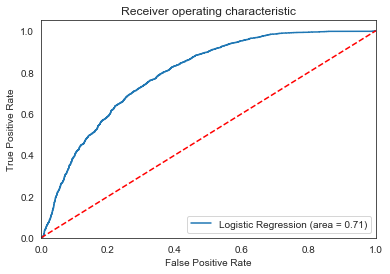

In [27]:
### Using SKleanr logistic Model
# 1 Hot Encoding

from sklearn.preprocessing import StandardScaler

y = closedIntroCalls_Data_logisticRegression['Target___IntroCall_Outcome_map']
X = closedIntroCalls_Data_logisticRegression.drop('Target___IntroCall_Outcome_map', axis = 1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=5)

sc = StandardScaler()  
Xlr = sc.fit_transform(Xlr)  
Xtestlr = sc.transform(Xtestlr) 

logreg = LogisticRegression()


# Fit the model on the trainng data.
logreg.fit(Xlr, ylr)
ylr_pred = logreg.predict(Xtestlr)

# Print the accuracy from the testing data.
print("Accuracy Score: ", accuracy_score(logreg.predict(Xtestlr), ytestlr))
print("\n")
print("Params: ", logreg.get_params)
print("\n")


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, logreg.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, logreg.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV

Cs = [ 0.1, 1, 10]
solvers = ['liblinear']
maxIters = [100,150,200]

param_grid = {'C':Cs, 'max_iter':maxIters}

logreg_cv = GridSearchCV(logreg,param_grid, cv=10)
logreg_cv.fit(Xlr, ylr)

print("Best parameter:",logreg_cv.best_params_)
print("Best score:",logreg_cv.best_score_)
print("Test set accuracy:",accuracy_score(ytestlr,logreg_cv.predict(Xtestlr)))

Best parameter: {'C': 1, 'max_iter': 100}
Best score: 0.7299003707136237
Test set accuracy: 0.726498696785404


## Performing Logistic Regression (Version 2 - Not Hot Encoding)

C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Accuracy Score:  0.6783666377063423


Params:  <bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)>




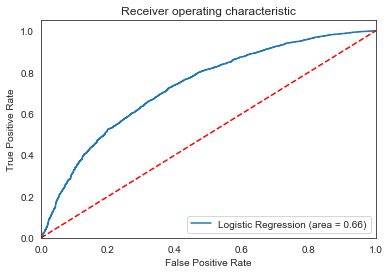

In [29]:
### Using SKleanr logistic Model
# Not 1 Hot Encoding 

from sklearn.preprocessing import StandardScaler

yProd = closedIntroCalls_wProducts_Data_logisticRegression_products['Target___IntroCall_Outcome_map']
XProd = closedIntroCalls_wProducts_Data_logisticRegression_products.drop('Target___IntroCall_Outcome_map', axis = 1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr_pr, Xtestlr_pr, ylr_pr, ytestlr_pr = train_test_split(XProd,yProd,random_state=5)

sc_pr = StandardScaler()  
Xlr_pr = sc_pr.fit_transform(Xlr_pr)  
Xtestlr_pr = sc_pr.transform(Xtestlr_pr) 

logreg_pr = LogisticRegressionCV()


# Fit the model on the trainng data.
logreg_pr.fit(Xlr_pr, ylr_pr)
ylr_pr_pred = logreg_pr.predict(Xtestlr_pr)

# Print the accuracy from the testing data.
print("Accuracy Score: ", accuracy_score(logreg_pr.predict(Xtestlr_pr), ytestlr_pr))
print("\n")
print("Params: ", logreg_pr.get_params)
print("\n")


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_pr = roc_auc_score(ytestlr_pr, logreg_pr.predict(Xtestlr_pr))
fpr_pr, tpr_pr, thresholds_pr = roc_curve(ytestlr_pr, logreg_pr.predict_proba(Xtestlr_pr)[:,1])
plt.figure()
plt.plot(fpr_pr, tpr_pr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_pr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random Forest - Predicting whether demo call is qualified

## Version 1 -  Hot Encoded

In [30]:
#This iteration uses the logistic regression cleaned momdel
#Uses 1 Hot encoding

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve


y_rf = closedIntroCalls_Data_logisticRegression['Target___IntroCall_Outcome_map']
X_rf = closedIntroCalls_Data_logisticRegression.drop('Target___IntroCall_Outcome_map', axis = 1)

# Split dataset into training set and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3) # 70% training and 30% test



sc = StandardScaler()  
X_train_rf = sc.fit_transform(X_train_rf)  
X_test_rf = sc.transform(X_test_rf) 

#Create a Gaussian Classifier
rf=RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train_rf,y_train_rf)

feature_imp = pd.Series(rf.feature_importances_,index=X_rf.columns).sort_values(ascending=False)
feature_imp_list = pd.DataFrame(feature_imp)
feature_imp_list.to_csv('randomForest1_featureImportance.csv')
print("Feature Imp: ")
print(feature_imp_list)
print("-----------------------------------------------------------------")

y_pred_rf = rf.predict(X_test_rf)



C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Feature Imp: 
                                                           0
inferScore___Lead_AddedInfo                         0.113925
totalEMails___Lead_AddedInfo                        0.092825
totalCalls___Lead_AddedInfo                         0.083597
introCallCreated_leadCreated_delta                  0.069080
assignedToRole___IntroCall_OtherInfo_map            0.063203
mnth_createddate___IntroCall_ImportantSystemInf...  0.053600
product2___IntroCall_MeetingDetails_WalkMe for ...  0.052097
mnth_createddate___Lead_ImportantSystemInfo_clean   0.050933
trafficChannel___Lead_MarketingInformation_map_map  0.042451
country___Lead_LeadCompanyInformation_map           0.042332
createdDayOFWeek___IntroCall_AddedInfo_map          0.041345
customerType___Lead_LeadCompanyInformation_map      0.035207
customerOrEmployee___IntroCall_MeetingDetails_map   0.032951
year_createddate___IntroCall_ImportantSystemInf...  0.031758
employeeCategory___Lead_AddedInfo_map               0.023773
year_creat

In [31]:
print("\n")
print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_rf,y_pred_rf))
print("---------------------------------------------------------------------")
print("\n")
print("Classification Report:")  
print(classification_report(y_test_rf,y_pred_rf))
print("----------------------------------------------------------------------")
print("\n")
print("Accuracy Score: ",accuracy_score(y_test_rf, y_pred_rf)) 
print("----------------------------------------------------------------------")
print("\n")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_rf = rf.predict(X_train_rf)
print(confusion_matrix(y_train_rf,y_pred_rf))
print("\n")





Confusion Matrix (Test Set): 
[[2224  830]
 [ 940 2912]]
---------------------------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      3054
           1       0.78      0.76      0.77      3852

   micro avg       0.74      0.74      0.74      6906
   macro avg       0.74      0.74      0.74      6906
weighted avg       0.74      0.74      0.74      6906

----------------------------------------------------------------------


Accuracy Score:  0.7437011294526499
----------------------------------------------------------------------


Confusion Matrix (Train Set): 
[[7009   71]
 [  89 8944]]




No handles with labels found to put in legend.


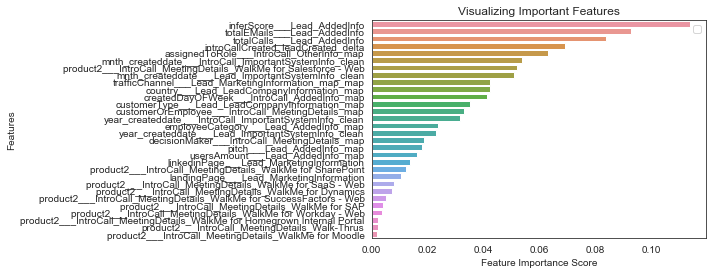

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:30], y=feature_imp.index[:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
print("\n")

In [33]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot


# Pull out one tree from the forest
tree = rf.estimators_[5]


# Export the image to a dot file
feature_list = list(X_rf.columns)
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree_rf.png');


# Limit depth of tree to 2 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(X_train_rf,y_train_rf)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree_rf.png');

In [34]:
print('Parameters currently in use:\n')
rf.get_params()

Parameters currently in use:



{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

rf_random.best_params_




{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [36]:

# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [400],
 'min_samples_split': [7, 10, 13],
 'min_samples_leaf': [1,3,5],
 'max_features': ['sqrt'],
 'max_depth': [20,40,50,60],
 'bootstrap': [False]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_rf, y_train_rf)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 16.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [400], 'min_samples_split': [7, 10, 13], 'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt'], 'max_depth': [20, 40, 50, 60], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [37]:
print("Best parameter:",grid_search.best_params_)
print("Best score:",grid_search.best_score_)
print("Test set accuracy:",accuracy_score(y_test_rf,grid_search.predict(X_test_rf)))

Best parameter: {'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}
Best score: 0.7901694284118413
Test set accuracy: 0.7903272516652187


## Version 2 - Not Hot Encoded

In [38]:
#This iteration uses the logistic regression cleaned momdel
# Not 1 Hot encoding - Products as a list


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve


yProd_rf = closedIntroCalls_wProducts_Data_logisticRegression_products['Target___IntroCall_Outcome_map']
XProd_rf = closedIntroCalls_wProducts_Data_logisticRegression_products.drop('Target___IntroCall_Outcome_map', axis = 1)

# Split dataset into training set and test set
X_train_pr_rf, X_test_pr_rf, y_train_pr_rf, y_test_pr_rf = train_test_split(XProd_rf, yProd_rf, test_size=0.3) # 70% training and 30% test



sc_pr_rf = StandardScaler()  
X_train_pr_rf = sc_pr_rf.fit_transform(X_train_pr_rf)  
X_test_pr_rf = sc_pr_rf.transform(X_test_pr_rf) 

#Create a Gaussian Classifier
clf_pr=RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_pr.fit(X_train_pr_rf,y_train_pr_rf)

feature_imp_pr = pd.Series(clf_pr.feature_importances_,index=XProd_rf.columns).sort_values(ascending=False)
print("Feature Imp: ")
feature_imp_pr_list = pd.DataFrame(feature_imp_pr)
feature_imp_pr_list.to_csv('randomForest2_featureImportance.csv')
print(feature_imp_pr_list)
print("-----------------------------------------------------------------")
print("\n")

y_pred_pr_rf = clf_pr.predict(X_test_pr_rf)


C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Feature Imp: 
                                                           0
inferScore___Lead_AddedInfo                         0.125791
totalEMails___Lead_AddedInfo                        0.113275
totalCalls___Lead_AddedInfo                         0.098810
introCallCreated_leadCreated_delta                  0.087681
assignedToRole___IntroCall_OtherInfo_map            0.072087
mnth_createddate___IntroCall_ImportantSystemInf...  0.059484
mnth_createddate___Lead_ImportantSystemInfo_clean   0.053333
year_createddate___IntroCall_ImportantSystemInf...  0.045717
trafficChannel___Lead_MarketingInformation_map_map  0.044573
country___Lead_LeadCompanyInformation_map           0.044475
createdDayOFWeek___IntroCall_AddedInfo_map          0.043441
customerType___Lead_LeadCompanyInformation_map      0.037227
customerOrEmployee___IntroCall_MeetingDetails_map   0.037219
year_createddate___Lead_ImportantSystemInfo_clean   0.027207
employeeCategory___Lead_AddedInfo_map               0.025754
decisionMa

In [41]:
print('Parameters currently in use:\n')
clf_pr.get_params()

Parameters currently in use:



{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [42]:
print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_pr_rf,y_pred_pr_rf))
print("---------------------------------------------------------------------")
print("\n")
print("Classification Report:")  
print(classification_report(y_test_pr_rf,y_pred_pr_rf))
print("----------------------------------------------------------------------")
print("\n")
print("Accuracy Score: ",accuracy_score(y_test_pr_rf, y_pred_pr_rf)) 
print("----------------------------------------------------------------------")
print("\n")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_pr_rf = clf_pr.predict(X_train_pr_rf)
print(confusion_matrix(y_train_pr_rf,y_pred_pr_rf))
print("\n")


Confusion Matrix (Test Set): 
[[2084  929]
 [1097 2796]]
---------------------------------------------------------------------


Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67      3013
           1       0.75      0.72      0.73      3893

   micro avg       0.71      0.71      0.71      6906
   macro avg       0.70      0.70      0.70      6906
weighted avg       0.71      0.71      0.71      6906

----------------------------------------------------------------------


Accuracy Score:  0.7066319142774399
----------------------------------------------------------------------


Confusion Matrix (Train Set): 
[[7050   71]
 [ 147 8845]]




No handles with labels found to put in legend.


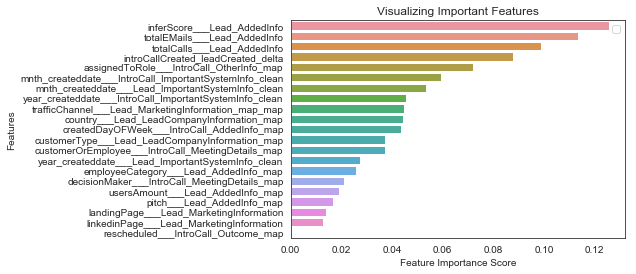

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp_pr, y=feature_imp_pr.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()
print("\n")



In [44]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot


# Pull out one tree from the forest
tree_pr = clf_pr.estimators_[5]


# Export the image to a dot file
feature_list_pr = list(XProd_rf.columns)
export_graphviz(tree_pr, out_file = 'tree_pr.dot', feature_names = feature_list_pr, rounded = True, precision = 1)

# Use dot file to create a graph
(graphpr, ) = pydot.graph_from_dot_file('tree_pr.dot')

# Write graph to a png file
graphpr.write_png('tree_rf_pr.png');


# Limit depth of tree to 2 levels
rf_small_pr = RandomForestClassifier(n_estimators=10, max_depth = 3, random_state=42)
rf_small_pr.fit(X_train_pr_rf,y_train_pr_rf)

# Extract the small tree
tree_small_pr = rf_small_pr.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small_pr, out_file = 'small_tree_pr.dot', feature_names = feature_list_pr, rounded = True, precision = 1)

(graphpr, ) = pydot.graph_from_dot_file('small_tree_pr.dot')

graphpr.write_png('small_tree_rf_pr.png');

## Gradient Boosted 

## Version 1 - Hot Encoded

In [45]:
#This iteration uses the logistic regression cleaned momdel
# Tjis one uses 1 Hot encoding

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



y_gb = closedIntroCalls_Data_logisticRegression['Target___IntroCall_Outcome_map']
X_gb = closedIntroCalls_Data_logisticRegression.drop('Target___IntroCall_Outcome_map', axis = 1)

# Split dataset into training set and test set
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb, y_gb, test_size=0.3) # 70% training and 30% test



sc = StandardScaler()  
X_train_gb = sc.fit_transform(X_train_gb)  
X_test_gb = sc.transform(X_test_gb) 

#Create a Gaussian Classifier
gb = XGBClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
gb.fit(X_train_gb,y_train_gb)

print(gb)

feature_imp_gb = pd.Series(gb.feature_importances_,index=X_gb.columns).sort_values(ascending=False)
feature_imp_gb_list = pd.DataFrame(feature_imp_gb)
feature_imp_gb_list.to_csv('gradientBoosted1_featureImportance.csv')
print("Feature Imp: ")
print(feature_imp_gb_list)
print("-----------------------------------------------------------------")



C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Feature Imp: 
                                                           0
year_createddate___IntroCall_ImportantSystemInf...  0.126935
totalEMails___Lead_AddedInfo                        0.100619
inferScore___Lead_AddedInfo                         0.071207
introCallCreated_leadCreated_delta                  0.068111
product2___IntroCall_MeetingDetails_WalkMe for ...  0.068111
totalCalls___Lead_AddedInfo                         0.063467
customerType___Lead_LeadCompanyInformation_map      0.060372
mnth_createddate___IntroCall_ImportantSystemInf...  0.052632
year_createddate___Lead_ImportantSystemInfo_clean

In [46]:
y_pred_gb = gb.predict(X_test_gb)

print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_gb,y_pred_gb))
print("---------------------------------------------------------------------")
print("Classification Report:")  
print(classification_report(y_test_gb,y_pred_gb))
print("----------------------------------------------------------------------")
print("Accuracy Score: ",accuracy_score(y_test_gb, y_pred_gb)) 
print("----------------------------------------------------------------------")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_gb = gb.predict(X_train_gb)
print(confusion_matrix(y_train_gb,y_pred_gb))





Confusion Matrix (Test Set): 
[[1861 1144]
 [ 467 3434]]
---------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70      3005
           1       0.75      0.88      0.81      3901

   micro avg       0.77      0.77      0.77      6906
   macro avg       0.77      0.75      0.75      6906
weighted avg       0.77      0.77      0.76      6906

----------------------------------------------------------------------
Accuracy Score:  0.766724587315378
----------------------------------------------------------------------
Confusion Matrix (Train Set): 
[[4637 2492]
 [ 942 8042]]


No handles with labels found to put in legend.


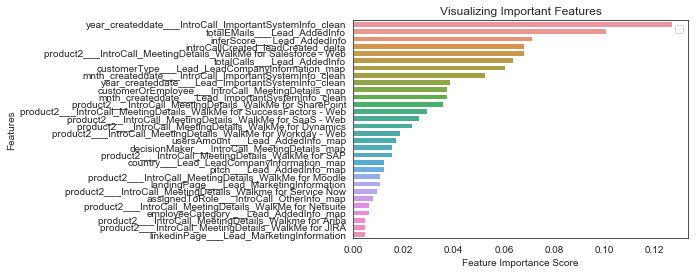

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp_gb[:30], y=feature_imp_gb.index[:30])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [48]:
print('Parameters currently in use:\n')
gb.get_params()

Parameters currently in use:



{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [49]:

### https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

from sklearn.model_selection import RandomizedSearchCV

minChildWeight = [1, 5, 10]
gama = [0.5, 1, 1.5, 2, 5]
subsampl = [0.6, 0.8, 1.0]
colSampbyTree = [0.6, 0.8, 1.0]
maxDepth = [3, 4, 5]

# Create the random grid
random_grid = {'min_child_weight': minChildWeight,
        'gamma': gama,
        'subsample': subsampl,
        'colsample_bytree': colSampbyTree,
        'max_depth': maxDepth}


# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, cv = 5)
# Fit the random search model
gb_random.fit(X_train_rf, y_train_rf)

gb_random.best_params_


{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 0.6}

In [50]:
# Create the parameter grid based on the results of random search 
param_grid = {'subsample': [1.0],
 'min_child_weight': [8,9,10,11,12,15],
 'max_depth': [4,5,6],
 'gamma': [1, 1.5, 2, 2.5, 3],
 'colsample_bytree': [1.0]}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_gb, y_train_gb)
grid_search.best_params_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 22.5min finished


{'colsample_bytree': 1.0,
 'gamma': 1,
 'max_depth': 6,
 'min_child_weight': 9,
 'subsample': 1.0}

In [51]:
print("Best parameter:",grid_search.best_params_)
print("Best score:",grid_search.best_score_)
print("Test set accuracy:",accuracy_score(y_test_gb,grid_search.predict(X_test_gb)))

Best parameter: {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 1.0}
Best score: 0.7926518959846087
Test set accuracy: 0.7930784824790038


## Version 2 - Not Hot Encoded

In [52]:
#This iteration uses the logistic regression cleaned momdel
#This one doesn't use 1 Hot encoding

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_gb_pr = closedIntroCalls_wProducts_Data_logisticRegression_products['Target___IntroCall_Outcome_map']
X_gb_pr = closedIntroCalls_wProducts_Data_logisticRegression_products.drop('Target___IntroCall_Outcome_map', axis = 1)



# Split dataset into training set and test set
X_train_gb_pr, X_test_gb_pr, y_train_gb_pr, y_test_gb_pr = train_test_split(X_gb_pr, y_gb_pr, test_size=0.3) # 70% training and 30% test



sc_pr = StandardScaler()  
X_train_gb_pr = sc_pr.fit_transform(X_train_gb_pr)  
X_test_gb_pr = sc_pr.transform(X_test_gb_pr) 

#Create a Gaussian Classifier
gb_pr = XGBClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
gb_pr.fit(X_train_gb_pr,y_train_gb_pr)

print(gb_pr)

feature_imp_pr = pd.Series(gb_pr.feature_importances_,index=X_gb_pr.columns).sort_values(ascending=False)
feature_imp_pr_list = pd.DataFrame(feature_imp_pr)
feature_imp_pr_list.to_csv('gradientBoosted2_featureImportance.csv')
print("Feature Imp: ")
print(feature_imp_pr_list)
print("-----------------------------------------------------------------")

y_pred_gb_pr = gb_pr.predict(X_test_gb_pr)


C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\mikiko.b\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Feature Imp: 
                                                           0
totalEMails___Lead_AddedInfo                        0.151429
introCallCreated_leadCreated_delta                  0.122857
totalCalls___Lead_AddedInfo                         0.104286
year_createddate___IntroCall_ImportantSystemInf...  0.102857
inferScore___Lead_AddedInfo                         0.100000
customerType___Lead_LeadCompanyInformation_map      0.072857
assignedToRole___IntroCall_OtherInfo_map            0.055714
customerOrEmployee___IntroCall_MeetingDetails_map   0.038571
decisionMaker___IntroCall_MeetingDetails_map     

In [53]:
print("Confusion Matrix (Test Set): ")
print(confusion_matrix(y_test_gb_pr,y_pred_gb_pr))
print("---------------------------------------------------------------------")
print("Classification Report:")  
print(classification_report(y_test_gb_pr,y_pred_gb_pr))
print("----------------------------------------------------------------------")
print("Accuracy Score: ",accuracy_score(y_test_gb_pr, y_pred_gb_pr)) 
print("----------------------------------------------------------------------")

######### CM on train set
print("Confusion Matrix (Train Set): ")
y_pred_gb_pr = gb_pr.predict(X_train_gb_pr)
print(confusion_matrix(y_train_gb_pr,y_pred_gb_pr))

Confusion Matrix (Test Set): 
[[1903 1155]
 [ 677 3171]]
---------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      3058
           1       0.73      0.82      0.78      3848

   micro avg       0.73      0.73      0.73      6906
   macro avg       0.74      0.72      0.73      6906
weighted avg       0.74      0.73      0.73      6906

----------------------------------------------------------------------
Accuracy Score:  0.7347234289024037
----------------------------------------------------------------------
Confusion Matrix (Train Set): 
[[4576 2500]
 [1455 7582]]


In [54]:
print('Parameters currently in use:\n')
gb_pr.get_params()

Parameters currently in use:



{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

No handles with labels found to put in legend.


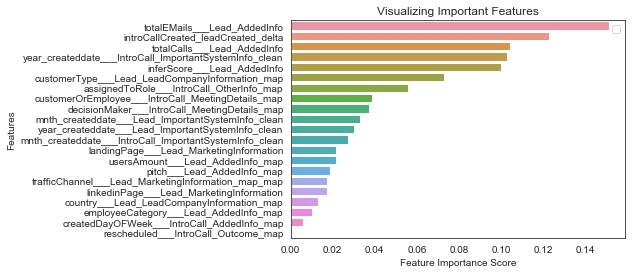

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp_pr, y=feature_imp_pr.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()